# Fine-tuning do BERTimbau com o dataset COVID.BR
Leonardo Azzi Martins, Giulia Chimini Stefainski, Matheus de Moraes Costa

---

**Objetivo:** realizar fine-tuning do modelo BERTimbau com o dataset COVID.BR, para classificação de desinformação em mensagens de texto do WhatsApp.

**Referências:**
- Laboratório 6 - Fine Tunnig BERT (Encoder), Prof. Dennis e Rafael Oleques
- [GitHub - Performing fine-tuning on BERT and BERTimbau models for text classification in Portuguese using the News Dataset in Portuguese](https://github.com/szanara/Bert-Bertimbau/blob/main/Bert_e_Bertimbal.ipynb)

![](https://www.aprendizartificial.com/wp-content/uploads/2024/02/JZ7Hynh.png)



# Setup

In [1]:
%pip install pandas transformers datasets torch scikit-learn evaluate seaborn imblearn accelerate>=0.26.0

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch
import torch.nn.functional as F
import os
from collections import defaultdict

# Preparação de dados
Carrega o dataset a ser utilizado para fine-tuning e seleciona os atributos mais relevantes.

In [3]:
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

Faz o download do dataset anotado no diretório ./data

In [4]:
import os

if not os.path.exists('./data/covidbr_labeled.csv'):
  !mkdir data
  !curl -L -o ./data/covidbr_labeled.csv https://zenodo.org/records/5193932/files/covidbr_labeled.csv
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [5]:
original_dataset_df = pd.read_csv('./data/covidbr_labeled.csv')
original_dataset_df

,shares,text,misinformation,source,revision
0,27,"O ministro da Ciência, Tecnologia, Inovações e...",0,https://www.gov.br/pt-br/noticias/educacao-e-p...,NaN
1,26,Pesquisa com mais de 6.000 médicos em 30 paíse...,1,https://www.aosfatos.org/noticias/e-falso-que-...,NaN
2,25,É com muita alegria que comunico que mais um p...,0,http://portal.mec.gov.br/component/content/art...,NaN
3,25,Renda Brasil unificará vários programas sociai...,0,https://agenciabrasil.ebc.com.br/politica/noti...,NaN
4,24,O Secretário-Geral da OTAN Jens Stoltenberg ta...,0,NaN,1.0
...,...,...,...,...,...
2894,1,A torcida do corona deve estar arrancando os c...,0,NaN,NaN
2895,1,“OS EUA E O CORONAVÍRUS :\n\nAcabei de assisti...,0,https://www.reuters.com/article/us-health-coro...,1.0
2896,1,Estatísticas falsas conforme depoimentos colhi...,1,NaN,1.0
2897,1,"Atenção => 🇧🇷💓💓💓 *MUITO IMPORTANTE! ""Como é qu...",0,NaN,NaN


In [6]:
dataset_df = original_dataset_df[["text", "misinformation"]]
dataset_df

,text,misinformation
0,"O ministro da Ciência, Tecnologia, Inovações e...",0
1,Pesquisa com mais de 6.000 médicos em 30 paíse...,1
2,É com muita alegria que comunico que mais um p...,0
3,Renda Brasil unificará vários programas sociai...,0
4,O Secretário-Geral da OTAN Jens Stoltenberg ta...,0
...,...,...
2894,A torcida do corona deve estar arrancando os c...,0
2895,“OS EUA E O CORONAVÍRUS :\n\nAcabei de assisti...,0
2896,Estatísticas falsas conforme depoimentos colhi...,1
2897,"Atenção => 🇧🇷💓💓💓 *MUITO IMPORTANTE! ""Como é qu...",0


# Análise exploratória de dados

O objetivo é entender melhor e sumarizar as características dos dados, analisando quantidade e tipos de atributos, verificando distribuição do atributo alvo, identificando padrões e anomalias, removendo atributos que pareçam irrelevantes ou problemáticos, etc. Utilize gráficos e sumarizações estatísticas para a EDA. Verifique potenciais problemas nos dados, como por exemplo, a necessidade de normalizar os atributos, balancear classes, ou remover instâncias ou atributos por inconsistências nos dados.

- P1. Qual a quantidade e tipos de atributos? Existem inconsistências?
  - Quais são os atributos disponíveis?
  - Existem inconsistências nos atributos? (Atributos vazios, potenciais erros, etc)
  - Existem atributos que necessitam ser removidos ou transformados?
- P2. Qual a distribuição do atributo alvo?
  - Quais são as classes alvo? Qual a distribuição entre as classes? Está balanceada ou desbalanceada?
- P3. Quais os padrões e anomalias dos atributos?



## P1. Qual a quantidade e tipos de atributos? Existem inconsistências?

Qual o tipo e a quantidade de itens não nulos de cada coluna?

In [7]:
dataset_df.info(verbose = True, memory_usage = False, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            2898 non-null   object
 1   misinformation  2899 non-null   int64 
dtypes: int64(1), object(1)

`text            2898 non-null`

Indicativo que existe 1 valor nulo em text.

Existem valores nulos em alguma das colunas?

In [8]:
dataset_df.isnull().any()

,0
text,True
misinformation,False


Visto que a coluna text são mensagens, substituir o valor nulo por uma string vazia, para viabilizar sua tokenização.

In [9]:
dataset_df = dataset_df.fillna("")
dataset_df.isnull().any()

,0
text,False
misinformation,False


## P2. Qual a distribuição do atributo alvo?

misinformation
0    1987
1     912
Name: count, dtype: int64


<Axes: xlabel='misinformation', ylabel='count'>

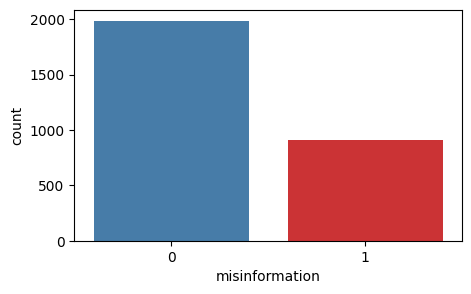

In [10]:
import seaborn as sns

series = dataset_df['misinformation'].value_counts()

print(series)

fig = plt.figure(figsize=(5, 3))

sns.countplot(x=dataset_df['misinformation'], data = dataset_df,
              hue='misinformation', legend=False, palette=['#377eb8', '#e41a1c'],
              order=dataset_df['misinformation'].value_counts().index
)

Isto indica que o dataset está desbalanceado, fator que pode enviesar o treinamento.

# Pré-processamento

## Tokenização

Carrega o tokenizador para `bert-base-portuguese-cased` (BERTimbau)

In [11]:
from transformers import AutoTokenizer  # Or BertTokenizer

hf_model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(hf_model_name, do_lower_case=False)

Aplica a tokenização para todas as instâncias de `text`

In [12]:
dataset_df.rename(columns={'misinformation': 'labels'})

,text,labels
0,"O ministro da Ciência, Tecnologia, Inovações e...",0
1,Pesquisa com mais de 6.000 médicos em 30 paíse...,1
2,É com muita alegria que comunico que mais um p...,0
3,Renda Brasil unificará vários programas sociai...,0
4,O Secretário-Geral da OTAN Jens Stoltenberg ta...,0
...,...,...
2894,A torcida do corona deve estar arrancando os c...,0
2895,“OS EUA E O CORONAVÍRUS :\n\nAcabei de assisti...,0
2896,Estatísticas falsas conforme depoimentos colhi...,1
2897,"Atenção => 🇧🇷💓💓💓 *MUITO IMPORTANTE! ""Como é qu...",0


In [13]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=300)

dataset_df = dataset_df.rename(columns={'misinformation': 'labels'})

# Divida o DataFrame em treinamento (80%) e uma parte temporária (20%)
df_train, df_temp = train_test_split(dataset_df, test_size=0.2, random_state=10)

# Divida a parte temporária em validação (50%) e teste (50%)
df_val, df_test = train_test_split(dataset_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

train_dataset_tk = train_dataset.map(tokenize_function, batched=True, remove_columns=['text']) #'__index_level_0__'
val_dataset_tk = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
test_dataset_tk = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

train_dataset_tk

Map:   0%|          | 0/2319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

Map:   0%|          | 0/1450 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2319
})

## Balanceamento de classes

Utilizando o cálculo de class_weights.

Fonte: https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = dataset_df["labels"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
print(class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float)

[0.7294917  1.58936404]


Fonte: https://discuss.huggingface.co/t/class-weights-for-bertforsequenceclassification/1674

In [ ]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss(weight=class_weights)

In [ ]:
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Fine-tuning

## Configuração

### Modelo

In [16]:
import torch

# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cpu


In [ ]:
from transformers import AutoModelForSequenceClassification

print(hf_model_name)
model = AutoModelForSequenceClassification.from_pretrained(hf_model_name,
                                                            num_labels=2)

print(model.config)
model.to(device)

In [ ]:
# # Freeze all layers except the classifier
# for param in model.bert.parameters():
#     param.requires_grad = False

# # Keep only the classification head trainable
# for param in model.classifier.parameters():
#     param.requires_grad = True

# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

### Treinador

In [17]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os

!mkdir -p models/covidbr_pt

# 4. Configurar o Trainer e os parâmetros de treino
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # print(preds)
    f1_mi = f1_score(labels, preds, average='micro')
    f1_ma = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1-macro': f1_ma,
        'f1-micro': f1_mi
    }

def train_bert(train_data, val_data):

  model = AutoModelForSequenceClassification.from_pretrained(hf_model_name,
                                                              num_labels=2)
  model.to(device)

  #setando os hiperparâmetros POR EPOCA
  batch_size = 8
  epochs = 5
  learning_rate = 3e-05
  steps_per_epoch = round(len(train_data) / batch_size)

  training_args = TrainingArguments(
    output_dir='test_trainer',
    overwrite_output_dir=True,
    eval_strategy='epoch',
    save_strategy ='epoch',
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    logging_steps=20,
    report_to="none",
    learning_rate=learning_rate,
    num_train_epochs = epochs,
    load_best_model_at_end = True,
    #   report_to='tensorboard'
  )

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # early_stopping_threshold=0.001
  )
  # trainer.label_names = ["label"]

  trainer.train()

  output_dir = 'models/covidbr_pt'

  # 6. Salvar modelo e tokenizer
  trainer.save_model(output_dir)
  tokenizer.save_pretrained(output_dir)

  # Recarregue o modelo do trainer e salve no formato .bin
  model.save_pretrained(output_dir, safe_serialization=False)

  # 7. Verificar arquivos
  print("Arquivos salvos:")
  print(os.listdir(output_dir))

  return trainer

### K-Fold Cross Validation

In [18]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Realiza a validação cruzada de um modelo, dado o número de folds e a métrica
def cross_validate_model(data, X, y, model, folds, metrics, metrics_df, rand_state):

  fold_results = []

  data = data.reset_index(drop=True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)

  # Avalia o modelo em k folds
  cv = StratifiedKFold(n_splits=folds, random_state=rand_state, shuffle=True)

  for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"=== Fold {fold + 1} ===")

    print(f"Fold {fold + 1}")

    train_df = data.iloc[train_idx]
    val_df = data.iloc[train_idx]

    # Convert to Hugging Face Dataset format
    train_dataset = train_df.to_dict(orient="list")
    val_dataset = val_df.to_dict(orient="list")

    trainer = train_bert(train_df, val_df)

    eval_result = trainer.evaluate()

    print(f"Fold {fold + 1} F1 Score: {eval_result['eval_f1']}")

    # # Organiza os resultados em um DataFrame

    # fold_scores = {'Fold': fold}
    # fold_scores.update({metric: scores[f'test_{metric}'][fold] for metric in metrics})
    # fold_df = pd.DataFrame(fold_scores, index=[0])
    # metrics_df = pd.concat([metrics_df, fold_df], ignore_index=True)

  return eval_result

## Treinamento

In [19]:
tk_dataset = tk_dataset_df.rename(columns={'misinformation': 'label'})
tk_dataset

NameError: name 'tk_dataset_df' is not defined

In [ ]:


X = tk_dataset_df.drop('labels', axis=1)
y = tk_dataset_df['labels']

k_folds = 5
random_state = 42
metrics = ['accuracy', 'f1-macro', 'f1-micro']
metrics_df = pd.DataFrame(columns=['Fold']+metrics)
cross_validate_model(tk_dataset_df, X, y, model, k_folds, metrics, metrics_df, random_state)

In [20]:
from transformers import Trainer

trainer = train_bert(train_dataset_tk, val_dataset_tk)

eval_result = trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# from transformers import Trainer
# from sklearn.metrics import f1_score
# from sklearn.model_selection import KFold

# fold_results = []

# # prepare cross validation
# k=5
# kf = KFold(n_splits=k, random_state=1, shuffle=True)

# for fold, (train_index, val_index) in enumerate(kf.split(data)):
#     print(f"Fold {fold + 1}")

#     # Split the data into training and validation sets
#     train_df = data.iloc[train_index]
#     val_df = data.iloc[val_index]

#     # Convert to Hugging Face Dataset format
#     train_dataset = train_df.to_dict(orient="list")
#     val_dataset = val_df.to_dict(orient="list")

#     # Create a Trainer instance
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=lambda p: {"f1": f1_score.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)["f1"]}
#     )

#     # Train the model
#     trainer.train()

#     # Evaluate the model
#     eval_result = trainer.evaluate()
#     print(f"Fold {fold + 1} F1 Score: {eval_result['eval_f1']}")
#     fold_results.append(eval_result['eval_f1'])

# # Calculate and print the mean F1 score
# mean_f1 = sum(fold_results) / len(fold_results)
# print(f"Mean F1 Score: {mean_f1}")

ref https://www.philschmid.de/k-fold-as-cross-validation-with-a-bert-text-classification-example